<a href="https://colab.research.google.com/github/neelsoumya/python_machine_learning/blob/main/pca_when_not_to_do.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A notebook to explain when to *not* apply PCA and how to apply tSNE

Generate synthetic "biological" expression matrix of 200 samples × 10 genes, where Gene_1 and Gene_2 follow an XOR‐style clustering (four corner clusters) and the remaining genes are just Gaussian noise. You can see from the scatter of Gene_1 vs Gene_2 that the true structure is non-linear and not aligned with any single variance direction—PCA would fail to unfold these XOR clusters into separate principal components.

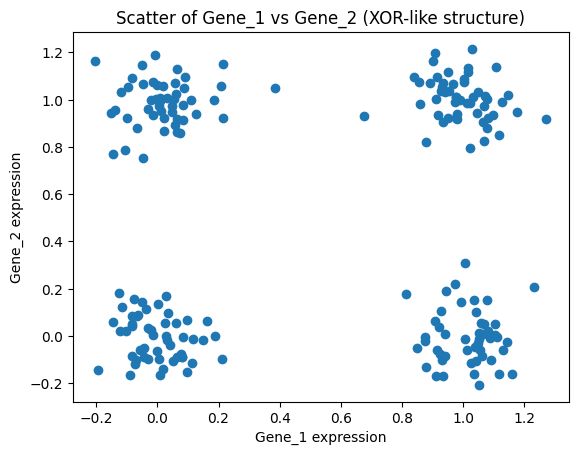

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 200
n_genes = 10

# Generate XOR structure for genes 1 and 2
gene1 = np.random.choice([0, 1], size=n_samples)
gene2 = np.array([np.random.choice([0, 1]) if g1 == 0 else np.random.choice([0, 1]) for g1 in gene1])
# Apply XOR: keep only points where gene1 XOR gene2 == 1 as cluster, but here keep all with label implicit
# For continuous spread, add small noise
gene1 = gene1 + 0.1 * np.random.randn(n_samples)
gene2 = gene2 + 0.1 * np.random.randn(n_samples)

# Generate remaining genes as random noise
other_genes = np.random.randn(n_samples, n_genes - 2)

# Combine into a DataFrame
data = np.hstack([gene1.reshape(-1,1), gene2.reshape(-1,1), other_genes])
genes = [f'Gene_{i+1}' for i in range(n_genes)]
df = pd.DataFrame(data, columns=genes)


# Scatter plot for Gene_1 vs Gene_2 to visualize the non-linear structure
plt.figure()
plt.scatter(df['Gene_1'], df['Gene_2'])
plt.title('Scatter of Gene_1 vs Gene_2 (XOR-like structure)')
plt.xlabel('Gene_1 expression')
plt.ylabel('Gene_2 expression')
plt.show()



Use PCA on this data

Explained variance ratio of the first two PCs:
[0.15373829 0.14237123]


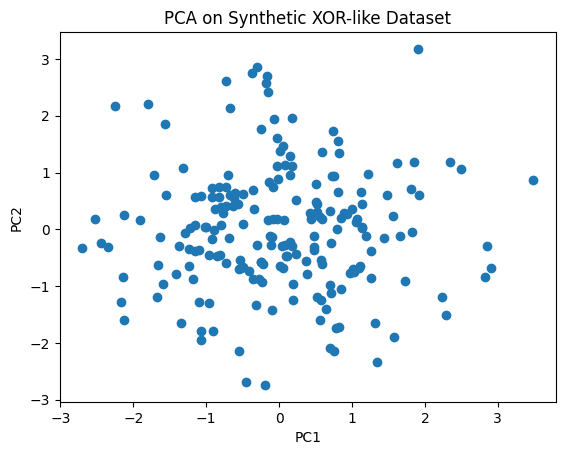

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the previous dataset generation
# If not, regenerate the dataset as shown before.

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(df)

# Print explained variance ratio
print("Explained variance ratio of the first two PCs:")
print(pca.explained_variance_ratio_)

# Scatter plot of the first two principal components
plt.figure()
plt.scatter(pcs[:, 0], pcs[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Synthetic XOR-like Dataset')
plt.show()


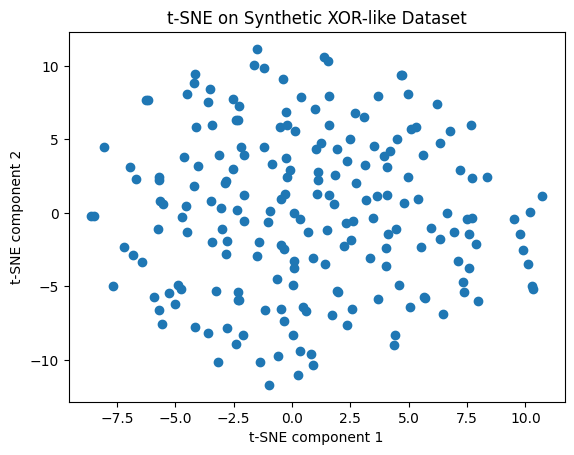

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the dataset generation

# Apply t-SNE
# It's often beneficial to reduce the dimensionality first with PCA before applying t-SNE
# especially for larger datasets or higher dimensions, but for this small dataset,
# we can apply t-SNE directly.
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df)

# Scatter plot of the t-SNE results
plt.figure()
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE on Synthetic XOR-like Dataset')
plt.show()

### Exploring t-SNE Perplexity

The `perplexity` parameter in t-SNE is related to the number of nearest neighbors used in the algorithm. It can have a significant impact on the resulting visualization. Let's see how different perplexity values affect the output for our synthetic dataset. The paper "How to Use t-SNE Effectively" suggests trying values between 5 and 50.

https://distill.pub/2016/misread-tsne/


Running t-SNE with perplexity=2...
Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...
Running t-SNE with perplexity=100...


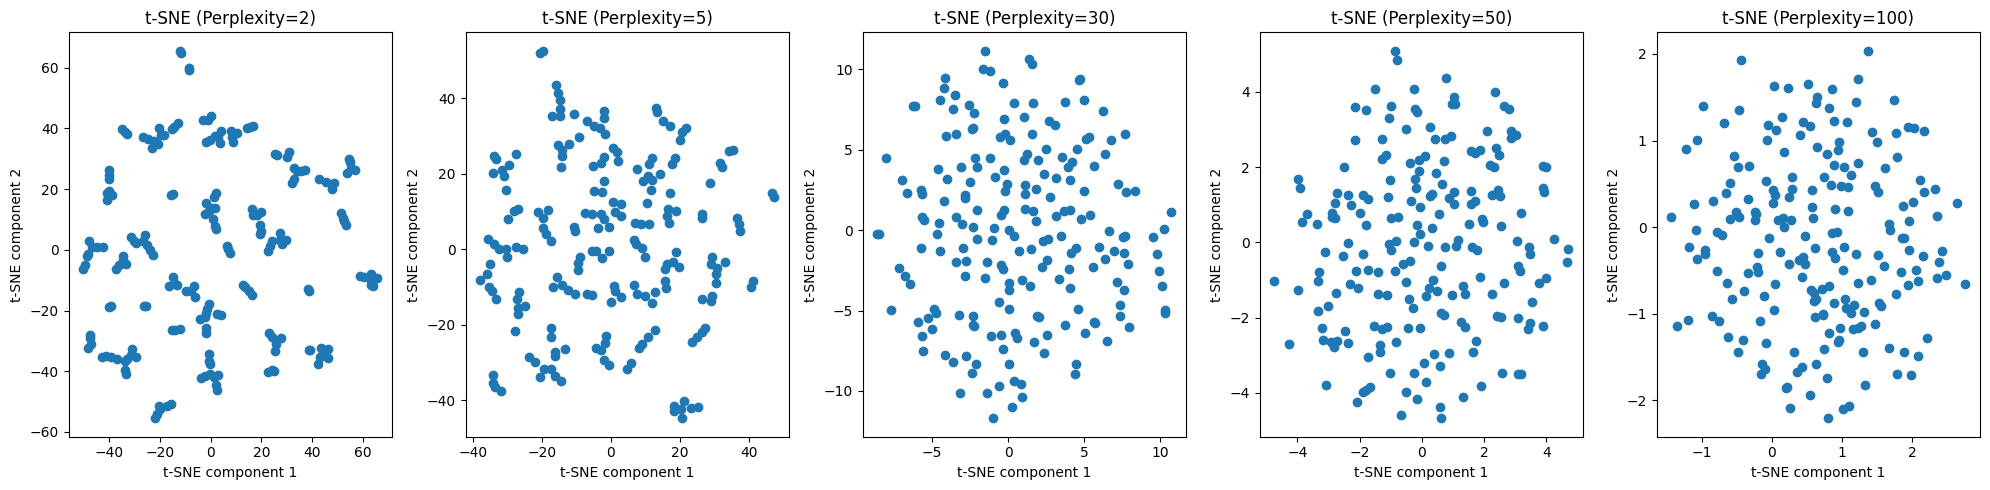

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume 'df' already exists in the workspace from the dataset generation

# Convert DataFrame to numpy array
data = df.values

# Define different perplexity values to explore
perplexities = [2, 5, 30, 50, 100] # Exploring values between 2 and 100

plt.figure(figsize=(20, 5)) # Adjust figure size for more subplots

for i, perplexity in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results = tsne.fit_transform(data)

    # Create a subplot for each perplexity value
    plt.subplot(1, len(perplexities), i + 1)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.title(f't-SNE (Perplexity={perplexity})')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

### Kernel PCA

Let's apply Kernel PCA to the synthetic dataset. We will use a radial basis function (RBF) kernel, which is commonly used for capturing non-linear relationships.

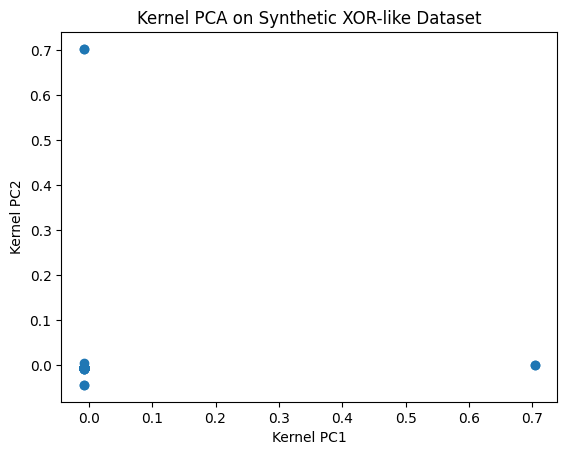

In [11]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the dataset generation

# Apply Kernel PCA with an RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10) # Gamma is a parameter for the RBF kernel
kpcs = kpca.fit_transform(df)

# Scatter plot of the first two kernel principal components
plt.figure()
plt.scatter(kpcs[:, 0], kpcs[:, 1])
plt.xlabel('Kernel PC1')
plt.ylabel('Kernel PC2')
plt.title('Kernel PCA on Synthetic XOR-like Dataset')
plt.show()

Use autoencoder on this data

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


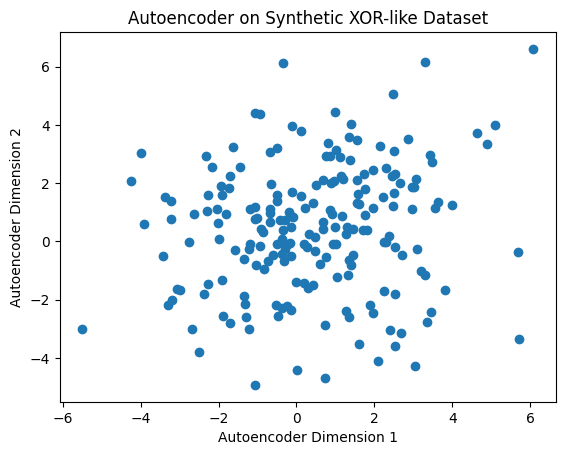

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the dataset generation

# Convert DataFrame to numpy array
data = df.values.astype(np.float32)

# Define the Autoencoder model
input_dim = data.shape[1]
encoding_dim = 2 # We want to reduce to 2 dimensions for visualization

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder_output = Dense(encoding_dim, activation='linear')(encoder) # Linear activation for the bottleneck

# Decoder
decoder = Dense(32, activation='relu')(encoder_output)
decoder = Dense(64, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='linear')(decoder) # Linear activation for output

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
# Use a smaller batch size and more epochs for potentially better learning of structure
history = autoencoder.fit(data, data,
                          epochs=100, # Increased epochs
                          batch_size=16, # Decreased batch size
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0) # Set verbose to 0 to reduce output during training

# Create a separate encoder model to get the reduced dimensions
encoder_model = Model(inputs=input_layer, outputs=encoder_output)

# Get the reduced dimensions
encoded_data = encoder_model.predict(data)

# Scatter plot of the autoencoder's reduced dimensions
plt.figure()
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel('Autoencoder Dimension 1')
plt.ylabel('Autoencoder Dimension 2')
plt.title('Autoencoder on Synthetic XOR-like Dataset')
plt.show()

# Optional: Plot training loss
# plt.figure()
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.title('Autoencoder Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Generating Synthetic Data: Multiple Gaussian Clusters

Inspired by the examples in "How to Use t-SNE Effectively", let's generate a synthetic dataset consisting of multiple distinct Gaussian clusters in a higher-dimensional space. This type of data is often used to illustrate how t-SNE can reveal clustering structure.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 300 # Increase samples to have more points per cluster
n_features = 20 # Higher dimension
n_clusters = 5 # Number of distinct clusters

# Generate data for each cluster
data_list = []
labels = []

for i in range(n_clusters):
    # Generate cluster center
    center = np.random.randn(n_features) * 5 # Spread centers out
    # Generate points around the center
    cluster_data = center + np.random.randn(n_samples // n_clusters, n_features) * 1.5 # Add some variance
    data_list.append(cluster_data)
    labels.extend([i] * (n_samples // n_clusters))

# Combine data from all clusters
data = np.vstack(data_list)
labels = np.array(labels)

# Convert to DataFrame
features = [f'Feature_{i+1}' for i in range(n_features)]
df_clusters = pd.DataFrame(data, columns=features)


# Note: Visualizing this directly in 2D is hard due to high dimensions.
# We will use dimensionality reduction techniques like t-SNE or PCA to visualize it later.
print(f"Generated dataset with shape: {df_clusters.shape}")
print(f"Generated labels with shape: {labels.shape}")

Generated dataset with shape: (300, 20)
Generated labels with shape: (300,)


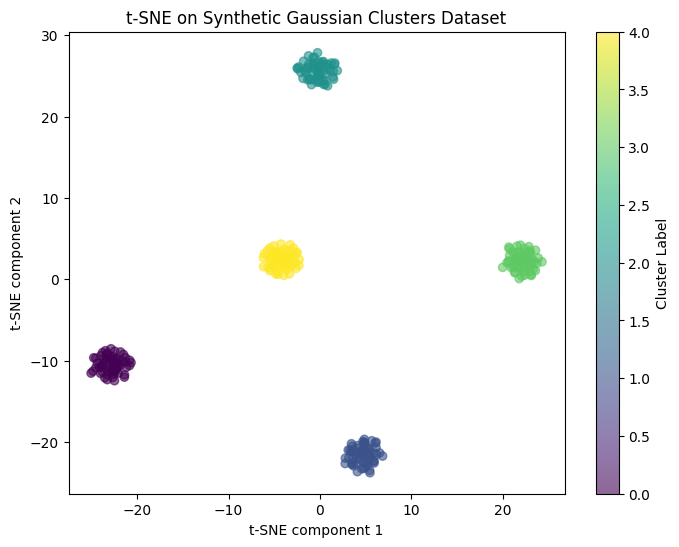

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume 'df_clusters' and 'labels' exist from the previous data generation step

# Apply t-SNE to the new dataset
tsne = TSNE(n_components=2, random_state=42)
tsne_results_clusters = tsne.fit_transform(df_clusters)

# Scatter plot of the t-SNE results, colored by true labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results_clusters[:, 0], tsne_results_clusters[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE on Synthetic Gaussian Clusters Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

Running t-SNE with perplexity=2...
Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...
Running t-SNE with perplexity=100...


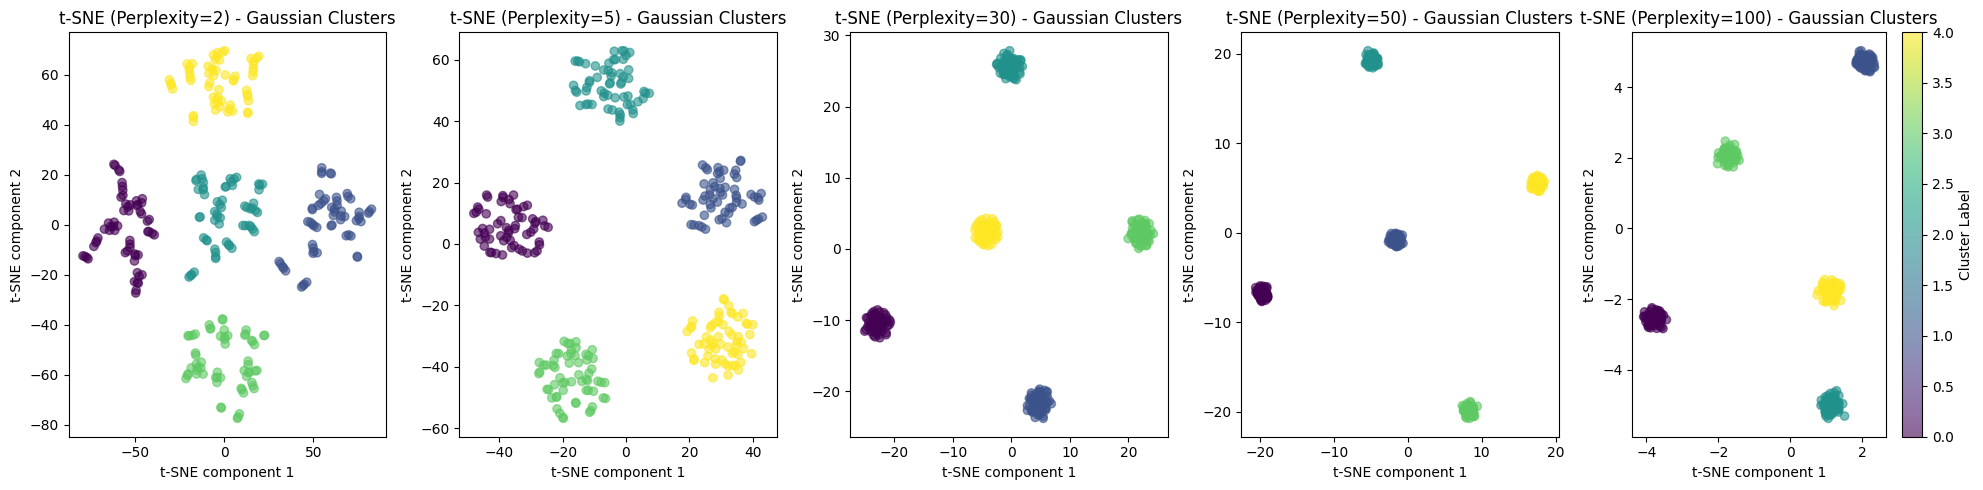

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume 'df_clusters' and 'labels' exist from the dataset generation

# Convert DataFrame to numpy array
data_clusters = df_clusters.values

# Define different perplexity values to explore
perplexities = [2, 5, 30, 50, 100] # Exploring values between 2 and 100

plt.figure(figsize=(20, 5)) # Adjust figure size for more subplots

for i, perplexity in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results_clusters = tsne.fit_transform(data_clusters)

    # Create a subplot for each perplexity value, colored by true labels
    plt.subplot(1, len(perplexities), i + 1)
    scatter = plt.scatter(tsne_results_clusters[:, 0], tsne_results_clusters[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f't-SNE (Perplexity={perplexity}) - Gaussian Clusters')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    # Add colorbar to the last subplot for clarity
    if i == len(perplexities) - 1:
        plt.colorbar(scatter, label='Cluster Label')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()